<a href="https://colab.research.google.com/github/JorgeZarama/Supervisado/blob/main/Actividad_C1_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convocatoria 1 - Proyecto 1
Jorge Andrés Zarama


#### 0) Cargar una de las imágenes histológicas

In [47]:
from skimage import io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
!pip install opencv-python
from scipy.ndimage import binary_fill_holes as bfh
from skimage.measure import label
from skimage.morphology import convex_hull_image
from skimage.measure import label
from skimage.measure import regionprops
!pip install feret
import feret

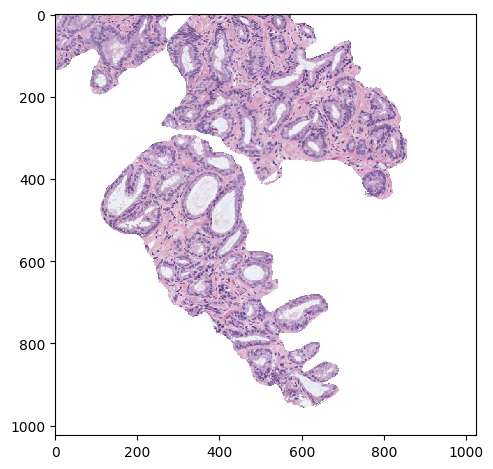

In [49]:


# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
img = io.imread('histo_2.jpg')

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
img_1_nor = img.copy()
img_1_nor = img_1_nor.astype('uint8')/255

# Visualizar la imagen
io.imshow(img_1_nor, cmap='gray')
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

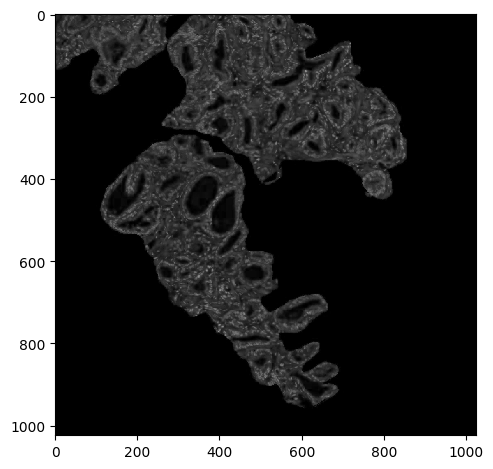

In [50]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(img_1_nor, axis=2)
    C = (1-img_1_nor[:,:,0]-K)/(1-K)
    M = (1-img_1_nor[:,:,1]-K)/(1-K)
    Y = (1-img_1_nor[:,:,2]-K)/(1-K)

CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
C,M,Y,K = cv2.split(CMYK)


# Visualizar la imagen del canal magenta
io.imshow(M.astype('uint8'), cmap='gray')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

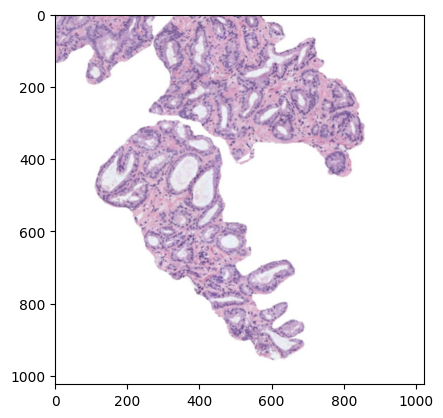

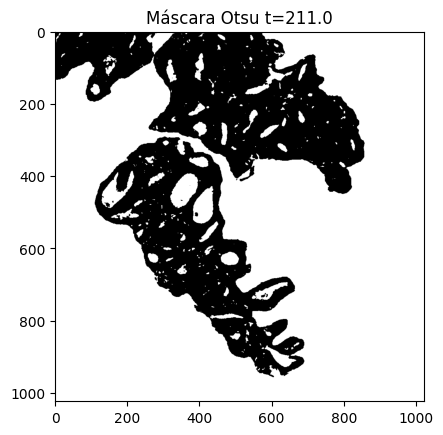

In [51]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.

img_gaus = cv2.GaussianBlur(img, (5,5), 0) # (5x5) size filtro y 0 es la desviación estándar
plt.imshow(img_gaus, cmap='gray')
plt.show()

img_1_gray = cv2.cvtColor(img_gaus, cv2.COLOR_BGR2GRAY)
t, mask = cv2.threshold(img_1_gray,0,1,cv2.THRESH_OTSU) # 0 es por defecto y 1 es el valor máximo de la máscara

plt.imshow(mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()

# Visualizar la máscara resultante

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

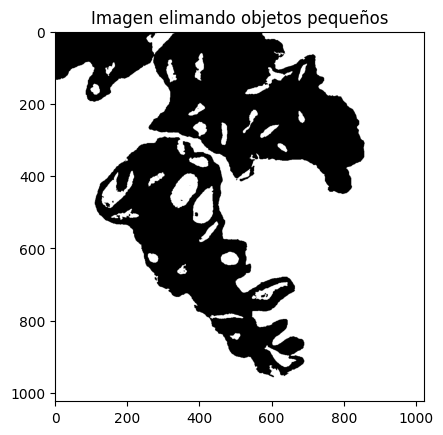

In [52]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

img_sin=skimage.morphology.remove_small_objects(mask.astype('bool'), min_size=300, connectivity=1, out=None)
plt.imshow(img_sin, cmap='gray')
plt.title('Imagen elimando objetos pequeños')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

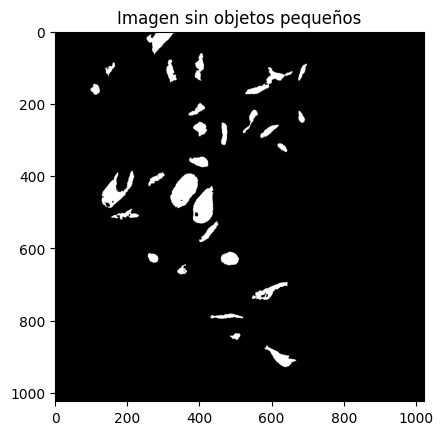

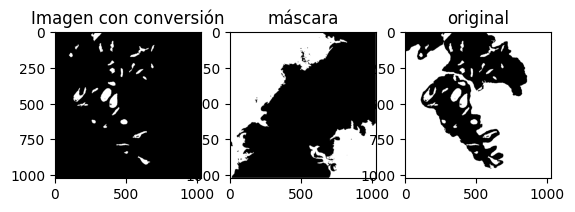

In [53]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.

mask_1 = img_sin.copy()
mask_1=mask_1*255


h, w = mask_1.shape
img_ref = np.zeros((h+2, w+2), np.uint8) # Definir una imagen para referencia negra

sop1 = np.zeros((h, w), np.uint8)
sop2 = np.zeros((h, w), np.uint8)

mask_2 = (np.dstack((mask_1,sop1,sop2)).astype('uint8'))

# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) para rellenar a partir de ese punto
cv2.floodFill(mask_2, img_ref, (0,0), 0)# Es de interés dejar negro el relleno por lo cual tomamos ese color
cv2.floodFill(mask_2, img_ref, (1023,1023), 0) # y rellenamos la otra esquina

plt.imshow(mask_2[:,:,0], cmap='gray')
plt.title('Imagen sin objetos pequeños')
plt.show()

fig, ax = plt.subplots(1,3)
ax[0].imshow(mask_2[:,:,0], cmap='gray'), ax[0].set_title('Imagen con conversión')
ax[1].imshow(ref, cmap='gray'), ax[1].set_title('máscara')
ax[2].imshow(img_sin, cmap='gray'), ax[2].set_title('original')
plt.show()



#### 5) Rellenar los objetos de los lúmenes

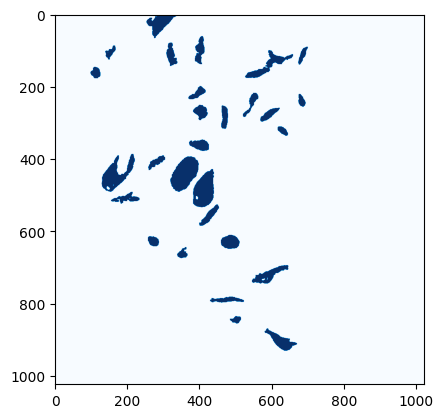

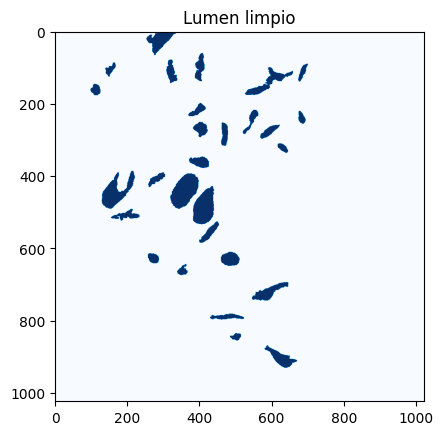

In [54]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

# Realizamos una detección de bordes usando de Canny
kernel = np.ones((2,2), 'uint8')
canny = cv2.dilate(mask_2[:,:,0], kernel, iterations=2)

plt.imshow(canny, cmap='Blues')
plt.show()

bordes = canny.copy()
filled_bordes = bfh(bordes)

plt.imshow(filled_bordes.astype('uint8'), cmap='Blues')#cambie el color para ver mejor los cambios
plt.title('Lumen limpio')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

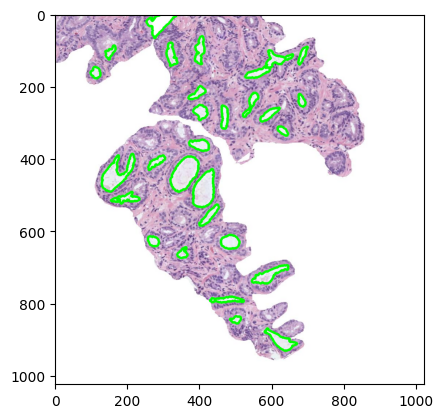

In [55]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta

# Convertimos la imagen binaria en una imagen de etiquetas para tener acceso a cada objeto por separado

lab, num = label(filled_bordes, return_num=True)

imagen = img.copy()
for x in range(1, num+1):
    objeto = lab == x
    objeto = objeto.astype('uint8')
    convex_image = convex_hull_image(objeto)
    convex_image = convex_image.astype('uint8')
    conts,_ = cv2.findContours(objeto, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imagen = cv2.drawContours(imagen, conts, -1, (0,255,0), 5)

plt.imshow(imagen, cmap='gray')
plt.show()

#### 7) Identificar y cropear el lumen más grande

Mayor:  18
Mayor área:  5051


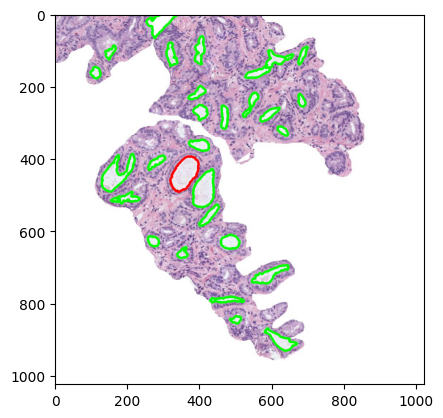

(394, 319, 492, 398)


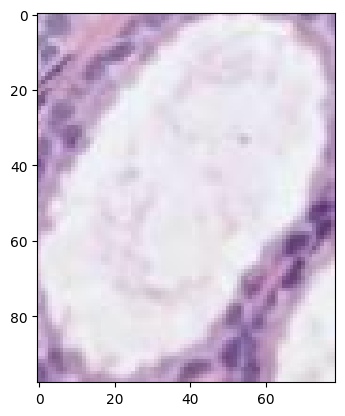

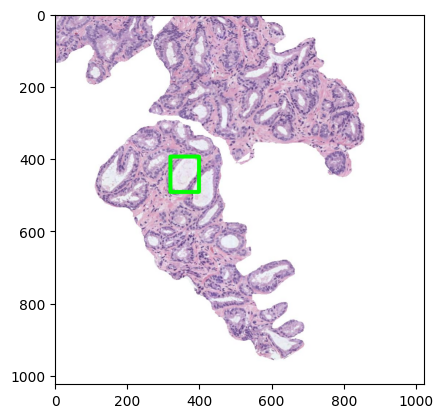

In [56]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

new_lab, new_num = label(filled_bordes.astype('uint8'), return_num=True)

# Extraemos las característicias geométricas en algunos arreglos
A,BB,CA,E,ED,EX,MA,MiA,OR,P,S,CO,R = ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'], ['major_axis'], ['minor_axis'], ['orientation'], ['perimeter'], ['solidity'], ['compactness'], ['rectangularity']

max_area=0
max_num=0

for i in range(1,new_num+1):
    objeto = new_lab == i
    prop = regionprops(objeto.astype(np.uint8))

    A.append(np.round(prop[0].area, 4))
    BB.append(np.round(prop[0].bbox_area, 4))
    CA.append(np.round(prop[0].convex_area, 4))
    E.append(np.round(prop[0].eccentricity, 4))
    ED.append(np.round(prop[0].equivalent_diameter, 4))
    EX.append(np.round(prop[0].extent, 4))
    MA.append(np.round(prop[0].major_axis_length, 4))
    MiA.append(np.round(prop[0].minor_axis_length, 4))
    OR.append(np.round(prop[0].orientation, 4))
    P.append(np.round(prop[0].perimeter, 4))
    S.append(np.round(prop[0].solidity, 4))
    CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))
    R.append(np.round(prop[0].area/prop[0].bbox_area, 4))

    if prop[0].area>max_area:
        max_area=prop[0].area
        max_num=i

my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO), tuple(R)]

print("Mayor: ", max_num)
print("Mayor área: ", max_area)
objeto = new_lab == max_num
objeto = objeto.astype('uint8')
conts,_ = cv2.findContours(objeto, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
imagen = cv2.drawContours(imagen, conts, -1, (255,0,0), 5)

plt.imshow(imagen, cmap='gray')
plt.show()

prop = regionprops(objeto)
bbox = prop[0].bbox
print(bbox)
start_point = (bbox[1], bbox[0])
end_point = (bbox[3], bbox[2])
window = cv2.rectangle(img.copy(), start_point, end_point, (0, 255, 0), 10)

new_img = img[bbox[0]:bbox[2], bbox[1]:bbox[3]]

plt.imshow(new_img, cmap='gray')
plt.show()

plt.imshow(window, cmap='gray')
plt.show()


#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [57]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad



objeto = lab == max_num
objeto = objeto.astype('uint8')
convex_image = convex_hull_image(objeto)
convex_image = convex_image.astype('uint8')

maxf = feret.max(convex_image)


print("1) Área: ",A[max_num])
print("2) Área de la bounding box: ",BB[max_num])
print("3) Área convexa: ",CA[max_num])
print("4) Exentricidad: ",E[max_num])
print("5) Diámetro equivalente: ",ED[max_num])
print("6) Extensión: ",EX[max_num])
print("7) Diámetro Feret: ",round(maxf,4))
print("8) Longitud del eje mayor: ",MA[max_num])
print("9) Longitud del eje menor: ",MiA[max_num])
print("10) Orientación: ",OR[max_num])
print("11) Perímetro: ",P[max_num])
print("12) Solidez: ",S[max_num])
print("13) Compacidad: ",CO[max_num])




1) Área:  5051
2) Área de la bounding box:  7742
3) Área convexa:  5235
4) Exentricidad:  0.8293
5) Diámetro equivalente:  80.1943
6) Extensión:  0.6524
7) Diámetro Feret:  106.1744
8) Longitud del eje mayor:  107.5299
9) Longitud del eje menor:  60.0816
10) Orientación:  -0.5598
11) Perímetro:  293.9066
12) Solidez:  0.9649
13) Compacidad:  0.7348
